# 🚀 BERT Resume-Job Matcher Training

## ⚡ Quick Start - Dealing with Large Datasets

**If training is too slow:** 
1. **Interrupt the kernel** (stop button)
2. Adjust `SAMPLE_SIZE` in **Cell 7** (currently 10,000)
   - For quick testing: 5,000 samples (~2-3 hours)
   - For balanced training: 10,000 samples (~4-6 hours)
   - For better accuracy: 20,000 samples (~8-12 hours)
3. **Rerun from Cell 7** onwards

The notebook will automatically sample your data to make training feasible while maintaining label distribution.

In [7]:
import os
import sys
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoTokenizer, 
    AutoModelForSequenceClassification,
    TrainingArguments, 
    Trainer
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import Parallel, delayed
from tqdm import tqdm

In [8]:
sys.path.append(os.path.join(os.pardir, "utils"))

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.8.0+cpu
CUDA available: False


In [9]:
%load_ext autoreload
%autoreload 2
from utils import *

# Paths
DATA_DIR = os.path.join(os.pardir, "data")
CLUSTER_DIR = os.path.join(DATA_DIR, "clusters")
EMB_DIR = os.path.join(DATA_DIR, "embeddings")
OUTPUT_DIR = os.path.join(os.pardir, "data_outputs")
MODEL_DIR = os.path.join(os.pardir, "models", "bert_resume_matcher")

os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)

# File paths
resume_path = os.path.join(CLUSTER_DIR, "resumes_clustered.csv")
jobs_path = os.path.join(CLUSTER_DIR, "jobs_clustered.csv")
resume_emb_path = os.path.join(EMB_DIR, "resume_embeddings.npy")
job_emb_path = os.path.join(EMB_DIR, "job_embeddings.npy")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
resumes = pd.read_csv(resume_path)
jobs = pd.read_csv(jobs_path)
resume_embeddings = np.load(resume_emb_path)
job_embeddings = np.load(job_emb_path)

print(f"✅ Loaded {len(resumes)} resumes and {len(jobs)} jobs")
print(f"✅ Embeddings: {resume_embeddings.shape}, {job_embeddings.shape}")
print(f"\nResume columns: {resumes.columns.tolist()}")
print(f"Job columns: {jobs.columns.tolist()}")

✅ Loaded 2484 resumes and 5448 jobs
✅ Embeddings: (2484, 384), (5448, 384)

Resume columns: ['ID', 'Resume_str', 'Resume_html', 'Category', 'Resume_clean', 'DomainCluster', 'PredictedCluster', 'x', 'y', 'KeywordDomain', 'ClusterDomainLabel']
Job columns: ['jobpost', 'date', 'Title', 'Company', 'Location', 'JobDescription', 'JobRequirment', 'RequiredQual', 'Salary', 'ApplicationP', 'AboutC', 'Year', 'Month', 'IT', 'job_text', 'job_text_clean', 'PredictedCluster', 'KeywordDomain', 'ClusterDomainLabel', 'DomainCluster', 'x', 'y']


In [11]:
def calculate_composite_score(resume_text, job_text, resume_emb, job_emb,
                              resume_cluster, job_cluster, resume_domain, job_domain):
    """
    Calculate a composite matching score between resume and job.
    Returns final_score (0-1) and component scores dict.
    """
    # Semantic similarity (0-1)
    semantic_sim = float(cosine_similarity([resume_emb], [job_emb])[0][0])
    semantic_sim = max(0, min(1, semantic_sim))  # Clip to [0,1]
    
    # Domain match bonus
    domain_score = 1.0 if resume_domain == job_domain else 0.3
    
    # Cluster match bonus
    cluster_score = 1.0 if resume_cluster == job_cluster else 0.5
    
    # Simple keyword overlap (basic skills matching)
    resume_words = set(str(resume_text).lower().split())
    job_words = set(str(job_text).lower().split())
    
    common_words = resume_words & job_words
    keyword_score = min(len(common_words) / max(len(job_words), 1), 1.0) if job_words else 0
    
    # Weighted combination
    final_score = (
        0.40 * semantic_sim +
        0.25 * domain_score +
        0.20 * cluster_score +
        0.15 * keyword_score
    )
    
    # Ensure in [0,1]
    final_score = max(0, min(1, final_score))
    
    components = {
        'semantic_score': semantic_sim,
        'domain_score': domain_score,
        'cluster_score': cluster_score,
        'keyword_score': keyword_score
    }
    
    return final_score, components


def process_one_domain(domain, resumes, jobs, resume_embeddings, job_embeddings):
    """Process resume-job pairs within a single domain"""
    domain_resumes = resumes[resumes["ClusterDomainLabel"] == domain]
    domain_jobs = jobs[jobs["ClusterDomainLabel"] == domain]
    results = []
    
    if domain_jobs.empty or domain_resumes.empty:
        return results
    
    print(f"Processing domain: {domain} ({len(domain_jobs)} jobs × {len(domain_resumes)} resumes)")
    
    for j_idx, job_row in domain_jobs.iterrows():
        j_emb = job_embeddings[j_idx]
        job_cluster = job_row.get("PredictedCluster", -1)
        job_domain = job_row["ClusterDomainLabel"]
        
        for r_idx, resume_row in domain_resumes.iterrows():
            r_emb = resume_embeddings[r_idx]
            resume_cluster = resume_row.get("PredictedCluster", -1)
            resume_domain = resume_row["ClusterDomainLabel"]
            
            # Semantic similarity
            cos_sim = cosine_similarity([r_emb], [j_emb])[0][0]

            # Composite scoring
            final_score, components = calculate_composite_score(
                resume_row["Resume_clean"],
                job_row["job_text_clean"],
                r_emb, j_emb,
                resume_cluster, job_cluster,
                resume_domain, job_domain
            )
            
            result = {
                "resume_id": resume_row.get("ID", r_idx),
                "job_id": j_idx,
                "resume_text": resume_row["Resume_clean"],
                "job_text": job_row["job_text_clean"],
                "resume_domain": resume_domain,
                "job_domain": job_domain,
                "cosine_similarity": cos_sim,
                "final_score": final_score,
                "same_cluster": int(resume_cluster == job_cluster),
                "same_domain": 1,
                **components
            }
            results.append(result)
    
    return results

print("🚀 Generating training pairs across all domains...")
domains = sorted(set(resumes["ClusterDomainLabel"]) & set(jobs["ClusterDomainLabel"]))
print(f"Domains to process: {domains}")

# Use threading instead of multiprocessing to avoid serialization issues
all_results = []
for domain in domains:
    domain_results = process_one_domain(domain, resumes, jobs, resume_embeddings, job_embeddings)
    all_results.append(domain_results)

pairs_flat = [x for sublist in all_results for x in sublist]
training_pairs = pd.DataFrame(pairs_flat)

print(f"\n✅ Generated {len(training_pairs):,} resume-job pairs")

🚀 Generating training pairs across all domains...
Domains to process: ['Creative & Design', 'Education', 'Finance & Accounting', 'Other Services', 'Tech & IT']
Processing domain: Creative & Design (175 jobs × 268 resumes)
Processing domain: Education (833 jobs × 174 resumes)
Processing domain: Education (833 jobs × 174 resumes)
Processing domain: Finance & Accounting (772 jobs × 594 resumes)
Processing domain: Finance & Accounting (772 jobs × 594 resumes)
Processing domain: Other Services (1417 jobs × 273 resumes)
Processing domain: Other Services (1417 jobs × 273 resumes)
Processing domain: Tech & IT (2251 jobs × 213 resumes)
Processing domain: Tech & IT (2251 jobs × 213 resumes)

✅ Generated 1,516,714 resume-job pairs

✅ Generated 1,516,714 resume-job pairs


Score statistics:
count    1.516714e+06
mean     6.162329e-01
std      6.408095e-02
min      3.500000e-01
25%      5.726662e-01
50%      6.180735e-01
75%      6.594195e-01
max      8.539293e-01
Name: final_score, dtype: float64

Label distribution:
label_category
medium    758356
poor      379179
good      379179
Name: count, dtype: int64

Label distribution:
label_category
medium    758356
poor      379179
good      379179
Name: count, dtype: int64


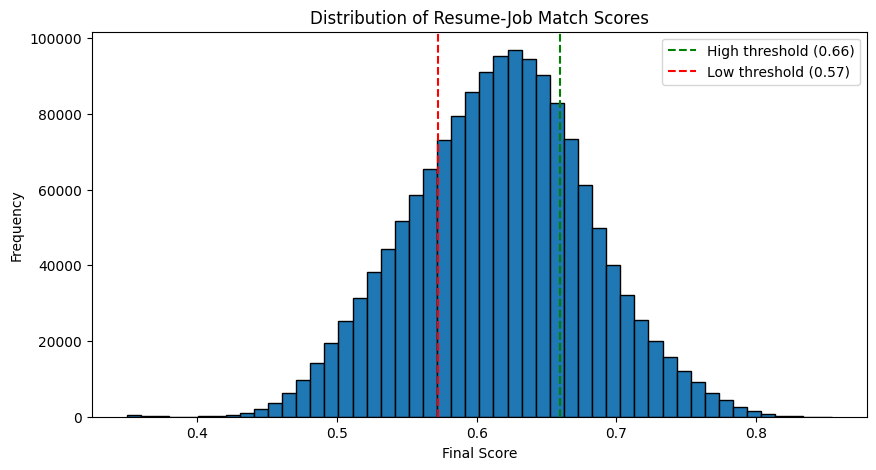

In [12]:
# Use final_score as continuous target (0-1 range)
scores = training_pairs["final_score"]
print(f"Score statistics:")
print(scores.describe())

# Create categorical labels for analysis
high_t = scores.quantile(0.75)
low_t = scores.quantile(0.25)

def assign_label_category(score):
    if score >= high_t:
        return "good"
    elif score <= low_t:
        return "poor"
    else:
        return "medium"

training_pairs["label_category"] = scores.apply(assign_label_category)
training_pairs["label"] = training_pairs["final_score"]  # Use continuous score

print(f"\nLabel distribution:")
print(training_pairs["label_category"].value_counts())

# Visualize score distribution
plt.figure(figsize=(10, 5))
plt.hist(training_pairs["label"], bins=50, edgecolor='black')
plt.axvline(high_t, color='g', linestyle='--', label=f'High threshold ({high_t:.2f})')
plt.axvline(low_t, color='r', linestyle='--', label=f'Low threshold ({low_t:.2f})')
plt.xlabel("Final Score")
plt.ylabel("Frequency")
plt.title("Distribution of Resume-Job Match Scores")
plt.legend()
plt.show()

In [ ]:
full_path = os.path.join(OUTPUT_DIR, "resume_job_training_data.csv")
training_pairs.to_csv(full_path, index=False)
print(f"✅ Saved full training data → {full_path}")

# Create BERT-ready dataset
bert_dataset = training_pairs[["resume_text", "job_text", "label"]].copy()
bert_dataset = bert_dataset.dropna()
bert_dataset["label"] = bert_dataset["label"].clip(0, 1)

# 🔥 SAMPLE DATA TO MAKE TRAINING FEASIBLE 🔥
# Take a stratified sample to keep label distribution
SAMPLE_SIZE = 10000  # Adjust this number based on your needs (5k-20k recommended)

if len(bert_dataset) > SAMPLE_SIZE:
    print(f"\n⚡ Sampling {SAMPLE_SIZE:,} pairs from {len(bert_dataset):,} total pairs...")
    
    # Stratified sampling based on label quantiles to maintain distribution
    bert_dataset['label_bin'] = pd.qcut(bert_dataset['label'], q=5, labels=False, duplicates='drop')
    bert_dataset_sampled = bert_dataset.groupby('label_bin', group_keys=False).apply(
        lambda x: x.sample(min(len(x), SAMPLE_SIZE // 5), random_state=42)
    )
    bert_dataset_sampled = bert_dataset_sampled.drop('label_bin', axis=1)
    bert_dataset = bert_dataset_sampled.reset_index(drop=True)
    
    print(f"✅ Sampled dataset size: {len(bert_dataset):,}")
    print(f"   Score range: [{bert_dataset['label'].min():.3f}, {bert_dataset['label'].max():.3f}]")
    print(f"   Score mean: {bert_dataset['label'].mean():.3f}")
else:
    print(f"✅ Dataset size is manageable: {len(bert_dataset):,}")

bert_path = os.path.join(OUTPUT_DIR, "bert_finetuning_dataset.csv")
bert_dataset.to_csv(bert_path, index=False)
print(f"✅ Saved BERT dataset → {bert_path}")
print(f"   Shape: {bert_dataset.shape}")

✅ Saved full training data → ..\data_outputs\resume_job_training_data.csv
✅ Saved BERT dataset → ..\data_outputs\bert_finetuning_dataset.csv
   Shape: (1515881, 3)
✅ Saved BERT dataset → ..\data_outputs\bert_finetuning_dataset.csv
   Shape: (1515881, 3)


In [14]:
train_df, temp_df = train_test_split(bert_dataset, test_size=0.3, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

print(f"Train set: {len(train_df):,} samples")
print(f"Validation set: {len(val_df):,} samples")
print(f"Test set: {len(test_df):,} samples")

Train set: 1,061,116 samples
Validation set: 227,382 samples
Test set: 227,383 samples


In [15]:
class ResumeJobDataset(Dataset):
    """Custom dataset for resume-job matching"""
    
    def __init__(self, dataframe, tokenizer, max_length=512):
        self.data = dataframe.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        
        # Combine resume and job text with [SEP] token
        text = f"{row['resume_text']} [SEP] {row['job_text']}"
        
        # Tokenize
        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(row['label'], dtype=torch.float)
        }
print("✅ Dataset class defined")

✅ Dataset class defined


In [16]:
MODEL_NAME = "bert-base-uncased"  # or "roberta-base"

print(f"Loading {MODEL_NAME}...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# For regression task (predicting similarity score)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=1,  # Regression task
    problem_type="regression"
)

print(f"✅ Model loaded: {model.config.model_type}")
print(f"   Parameters: {model.num_parameters():,}")

Loading bert-base-uncased...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Model loaded: bert
   Parameters: 109,483,009


In [17]:
train_dataset = ResumeJobDataset(train_df, tokenizer, max_length=512)
val_dataset = ResumeJobDataset(val_df, tokenizer, max_length=512)
test_dataset = ResumeJobDataset(test_df, tokenizer, max_length=512)

print("✅ Datasets created")
print(f"   Sample input shape: {train_dataset[0]['input_ids'].shape}")
print(f"   Sample label: {train_dataset[0]['labels'].item():.4f}")

✅ Datasets created
   Sample input shape: torch.Size([512])
   Sample label: 0.6301
   Sample input shape: torch.Size([512])
   Sample label: 0.6301


In [18]:
training_args = TrainingArguments(
    output_dir=MODEL_DIR,
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    weight_decay=0.01,
    warmup_steps=500,
    logging_dir=os.path.join(MODEL_DIR, 'logs'),
    logging_steps=100,
    eval_strategy="steps",
    eval_steps=500,
    save_steps=500,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    report_to="none",
    fp16=torch.cuda.is_available(),
)

print("✅ Training arguments configured")

✅ Training arguments configured


In [19]:
def compute_metrics(eval_pred):
    """Compute regression metrics"""
    predictions, labels = eval_pred
    predictions = predictions.flatten()
    
    mse = mean_squared_error(labels, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(labels, predictions)
    
    return {
        'mse': mse,
        'rmse': rmse,
        'mae': mae
    }

print("✅ Metrics function defined")

✅ Metrics function defined


In [20]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

print("✅ Trainer initialized")

✅ Trainer initialized


In [ ]:
# 🛑 STOP CURRENT TRAINING IF RUNNING
# If training is taking too long, interrupt the kernel and rerun from cell 7
# to apply the sampling

print(f"📊 Current dataset sizes:")
print(f"   Train: {len(train_dataset):,} samples")
print(f"   Val: {len(val_dataset):,} samples")
print(f"   Test: {len(test_dataset):,} samples")
print(f"\n⏱️ Estimated training time:")
print(f"   ~{len(train_dataset) * 3 / 3600:.1f} hours for 3 epochs (rough estimate)")
print(f"\n💡 If this is too long, restart kernel and rerun from cell 7 with smaller SAMPLE_SIZE")

In [21]:
print("🚀 Starting training...")
train_result = trainer.train()

print("\n✅ Training complete!")
print(f"   Training loss: {train_result.training_loss:.4f}")

# Save final model
trainer.save_model(MODEL_DIR)
tokenizer.save_pretrained(MODEL_DIR)
print(f"✅ Model saved to: {MODEL_DIR}")

🚀 Starting training...


c:\Users\adity\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss,Validation Loss


KeyboardInterrupt: 

In [ ]:
print("📊 Evaluating on test set...")
test_results = trainer.evaluate(test_dataset)

print("\n✅ Test Results:")
for key, value in test_results.items():
    print(f"   {key}: {value:.4f}")

In [ ]:
def predict_match_score(resume_text, job_text, model, tokenizer, device=None):
    """Predict match score between resume and job"""
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    model.eval()
    model.to(device)
    
    # Prepare input
    text = f"{resume_text} [SEP] {job_text}"
    encoding = tokenizer(
        text,
        max_length=512,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )
    
    # Move to device
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    
    # Predict
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        score = outputs.logits.item()
    
    # Clip to 0-1 range
    return max(0, min(1, score))

print("✅ Prediction function defined")

In [ ]:
sample_resume = test_df.iloc[0]['resume_text']
sample_job = test_df.iloc[0]['job_text']
true_score = test_df.iloc[0]['label']

predicted_score = predict_match_score(sample_resume, sample_job, model, tokenizer)

print(f"🔍 Sample Prediction:")
print(f"   True score: {true_score:.4f}")
print(f"   Predicted score: {predicted_score:.4f}")
print(f"   Difference: {abs(true_score - predicted_score):.4f}")

In [ ]:
print("📊 Getting predictions for entire test set...")
test_predictions = trainer.predict(test_dataset)
predicted_scores = test_predictions.predictions.flatten()
true_scores = test_df['label'].values

# Clip predictions to valid range
predicted_scores = np.clip(predicted_scores, 0, 1)

# Create results dataframe
results_df = pd.DataFrame({
    'true_score': true_scores,
    'predicted_score': predicted_scores,
    'error': np.abs(true_scores - predicted_scores)
})

print("\n✅ Prediction Statistics:")
print(results_df.describe())

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Scatter plot
axes[0, 0].scatter(true_scores, predicted_scores, alpha=0.5)
axes[0, 0].plot([0, 1], [0, 1], 'r--', label='Perfect prediction')
axes[0, 0].set_xlabel('True Score')
axes[0, 0].set_ylabel('Predicted Score')
axes[0, 0].set_title('True vs Predicted Scores')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Error distribution
axes[0, 1].hist(results_df['error'], bins=50, edgecolor='black')
axes[0, 1].set_xlabel('Absolute Error')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title(f'Error Distribution (MAE: {results_df["error"].mean():.4f})')
axes[0, 1].grid(True, alpha=0.3)

# 3. Residuals
residuals = true_scores - predicted_scores
axes[1, 0].scatter(predicted_scores, residuals, alpha=0.5)
axes[1, 0].axhline(y=0, color='r', linestyle='--')
axes[1, 0].set_xlabel('Predicted Score')
axes[1, 0].set_ylabel('Residual')
axes[1, 0].set_title('Residual Plot')
axes[1, 0].grid(True, alpha=0.3)

# 4. Score distributions
axes[1, 1].hist(true_scores, bins=30, alpha=0.5, label='True', edgecolor='black')
axes[1, 1].hist(predicted_scores, bins=30, alpha=0.5, label='Predicted', edgecolor='black')
axes[1, 1].set_xlabel('Score')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Score Distributions')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plot_path = os.path.join(MODEL_DIR, 'evaluation_plots.png')
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Plots saved to: {plot_path}")

In [ ]:
def find_top_k_jobs(resume_text, job_df, model, tokenizer, top_k=5, batch_size=32, device=None):
    """
    Find top-K matching jobs for a given resume using batched inference.
    
    Args:
        resume_text: String containing the resume
        job_df: DataFrame with 'job_text' or 'job_text_clean' column
        model: Fine-tuned BERT model
        tokenizer: Corresponding tokenizer
        top_k: Number of top matches to return
        batch_size: Batch size for inference
        device: 'cuda' or 'cpu'
    
    Returns:
        DataFrame with top-K jobs and their match scores
    """
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    model.eval()
    model.to(device)
    # Detect job text column
    job_col = None
    for col in ['job_text', 'job_text_clean', 'JobDescription']:
        if col in job_df.columns:
            job_col = col
            break
    
    if job_col is None:
        raise ValueError("job_df must contain a job text column")
    
    job_texts = job_df[job_col].fillna("").astype(str).tolist()
    scores = []
    
    print(f"🔍 Scoring {len(job_texts)} jobs in batches of {batch_size}...")
    
    with torch.no_grad():
        for i in tqdm(range(0, len(job_texts), batch_size)):
            batch_jobs = job_texts[i:i+batch_size]
            batch_texts = [f"{resume_text} [SEP] {jt}" for jt in batch_jobs]
            
            encodings = tokenizer(
                batch_texts,
                max_length=512,
                padding=True,
                truncation=True,
                return_tensors='pt'
            )
            
            
            input_ids = encodings['input_ids'].to(device)
            attention_mask = encodings['attention_mask'].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            batch_scores = outputs.logits.squeeze(-1).cpu().numpy()
            
            # Handle single prediction
            if batch_scores.ndim == 0:
                batch_scores = np.array([float(batch_scores)])
            
            scores.extend(batch_scores)
    
    # Clip scores to [0,1]
    scores = np.clip(scores, 0, 1)
    
    # Create results dataframe
    results = job_df.copy()
    results['match_score'] = scores
    results['job_preview'] = results[job_col].str[:200] + '...'
    
    # Sort and return top-K
    top_matches = results.nlargest(top_k, 'match_score')
    return top_matches[['match_score', 'job_preview'] + [c for c in ['Title', 'Company', 'Location'] if c in results.columns]]

print("✅ Top-K recommendation function defined")

In [ ]:
sample_resume_text = resumes.iloc[0]['Resume_clean']
print("📋 Sample Resume (first 300 chars):")
print(sample_resume_text[:300])
print("\n" + "="*80 + "\n")

# Find top 5 matching jobs
top_jobs = find_top_k_jobs(
    sample_resume_text, 
    jobs, 
    model, 
    tokenizer, 
    top_k=5,
    batch_size=32
)

print("🎯 Top 5 Job Matches:\n")
for idx, row in top_jobs.iterrows():
    print(f"Match Score: {row['match_score']:.4f}")
    if 'Title' in row:
        print(f"Title: {row['Title']}")
    print(f"Preview: {row['job_preview']}")
    print("-" * 80)

In [ ]:
def evaluate_top_k_accuracy(test_pairs, model, tokenizer, k_values=[1, 3, 5, 10]):
    """
    Evaluate how often the true matching job appears in top-K recommendations
    """
    from collections import defaultdict
    
    # Check if required columns exist
    if 'resume_id' not in test_pairs.columns or 'job_id' not in test_pairs.columns:
        print("⚠️ Warning: test_pairs missing 'resume_id' or 'job_id' columns")
        print("   Skipping top-K evaluation")
        return {}
    
    # Group by resume_id
    resume_groups = test_pairs.groupby('resume_id')
    
    accuracies = defaultdict(list)
    
    print(f"Evaluating top-K accuracy for {len(resume_groups)} unique resumes...")
    
    for resume_id, group in tqdm(list(resume_groups.items())[:100]):  # Sample 100 for speed
        try:
            # Get resume text
            resume_text = group.iloc[0]['resume_text']
            
            # Get true high-scoring jobs (top 25%)
            threshold = group['label'].quantile(0.75)
            true_good_jobs = set(group[group['label'] >= threshold]['job_id'])
            
            if not true_good_jobs:
                continue
            
            # Create mini job dataframe from this group
            mini_jobs = jobs.loc[group['job_id'].unique()].copy()
            
            if len(mini_jobs) < max(k_values):
                continue
            
            # Get predictions
            top_matches = find_top_k_jobs(
                resume_text, 
                mini_jobs, 
                model, 
                tokenizer, 
                top_k=max(k_values),
                batch_size=32
            )
            
            # Check accuracy for each k
            for k in k_values:
                top_k_indices = set(top_matches.head(k).index)
                hit = len(top_k_indices & true_good_jobs) > 0
                accuracies[k].append(int(hit))
        except Exception as e:
            print(f"⚠️ Error processing resume {resume_id}: {e}")
            continue
    
    # Calculate average accuracies
    results = {k: np.mean(acc) if acc else 0.0 for k, acc in accuracies.items()}
    
    return results

# Run evaluation (on subset for speed)
try:
    if 'resume_id' in training_pairs.columns and 'job_id' in training_pairs.columns:
        print("📊 Evaluating top-K accuracy...")
        k_accuracies = evaluate_top_k_accuracy(
            training_pairs[training_pairs['resume_id'].isin(resumes['ID'].sample(min(50, len(resumes))).values)],
            model,
            tokenizer,
            k_values=[1, 3, 5, 10]
        )
        
        if k_accuracies:
            print("\n✅ Top-K Accuracy Results:")
            for k, acc in k_accuracies.items():
                print(f"   Top-{k}: {acc:.2%}")
        else:
            print("⚠️ No results from top-K evaluation")
    else:
        print("⚠️ Skipping top-K evaluation (missing resume_id or job_id columns)")
except Exception as e:
    print(f"⚠️ Top-K evaluation failed: {e}")
    print("   This is optional - model training is complete")

In [ ]:
def load_model_and_recommend(resume_text, jobs_df, model_dir=MODEL_DIR, top_k=5):
    """
    Convenience function to load model and get recommendations.
    Use this in production/deployment.
    """
    # Load model and tokenizer
    model = AutoModelForSequenceClassification.from_pretrained(model_dir)
    tokenizer = AutoTokenizer.from_pretrained(model_dir)
    
    # Get recommendations
    return find_top_k_jobs(resume_text, jobs_df, model, tokenizer, top_k=top_k)

print("✅ Production-ready inference function defined")
print(f"\nTo use in production:")
print(f"  from model_utils import load_model_and_recommend")
print(f"  recommendations = load_model_and_recommend(resume_text, jobs_df, top_k=5)")